In [124]:
import os, sys
sys.path.append('/home/yann/work/physion/')
import numpy as np
from physion.dataviz.show_data import MultimodalData, Data
from physion.Ca_imaging.tools import compute_CaImaging_trace
from scipy.interpolate import interp1d
import matplotlib.pylab as plt

FILENAMES = ['2021_03_12-14-43-53.nwb',
            '2021_03_12-15-56-21.nwb',
            '2021_03_11-15-17-19.nwb',
            '2021_03_12-15-35-44.nwb',
            '2021_03_12-15-03-39.nwb',
            '2021_03_11-14-43-01.nwb']
        
NRN_CC, SUM_CC = [], []
for f in FILENAMES:
    NRN_CC.append([])
    filename = os.path.join(os.path.expanduser('~'), 'DATA', 'NDNF+', f)
    data = Data(filename, verbose=False)
    dtR = 0.03 # dt resampled: 30Hz
    # need to resample to compute the cross-correlation (they have different temporal sampling)
    t_resampled = np.arange(int((data.Neuropil.timestamps[-1]-data.Neuropil.timestamps[0])/dtR))*dtR+\
                        data.Neuropil.timestamps[0]
    # get pupil trace
    t_pupil = data.nwbfile.processing['Pupil'].data_interfaces['sx'].timestamps[:]
    diameter = data.nwbfile.processing['Pupil'].data_interfaces['sx'].data[:]*\
                               data.nwbfile.processing['Pupil'].data_interfaces['sy'].data[:]
    func = interp1d(t_pupil, diameter, kind='linear', bounds_error=False, fill_value="extrapolate")
    pupil = func(t_resampled)
    for i in np.argwhere(~np.isfinite(pupil)).flatten():
        pupil[i]=pupil[i-1] # need to clean up the pupil trace
    for icell in range(np.sum(data.iscell)):
        dF = compute_CaImaging_trace(data, 'dF/F', [icell]).sum(axis=0)
        funcN = interp1d(data.Neuropil.timestamps[:], dF, fill_value=(0,0), bounds_error=False)
        dFr = funcN(t_resampled)
        NRN_CC[-1].append(np.corrcoef(pupil, dFr)[0,1])
    # then sum
    dFS = compute_CaImaging_trace(data, 'dF/F', np.arange(np.sum(data.iscell))).sum(axis=0)
    funcS = interp1d(data.Neuropil.timestamps[:], dFS, bounds_error=False, fill_value=0)
    dFrS = funcS(t_resampled)
    SUM_CC.append(np.corrcoef(pupil, dFrS)[0,1])
    data.io.close()

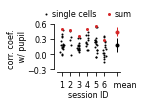

In [125]:
from datavyz import ge

fig, ax = ge.figure(figsize=(1,1))
bins = np.linspace(-0.2, 0.8, 20)
for i, nrn_cc in enumerate(NRN_CC):
    
    ge.scatter(np.random.randn(len(nrn_cc))*.1+i+1, nrn_cc, label=('single cells' if i==0 else None), ax=ax, no_set=True, ms=1)
    ge.scatter([i+1], SUM_CC[i], label=('sum' if i==0 else None), ax=ax, no_set=True, ms=2, color=ge.red)
    
nrns = np.concatenate(NRN_CC)
ge.scatter([7.5], [nrns.mean()], sy=[nrns.std()], ax=ax, no_set=True, ms=3)
ge.scatter([7.5], [np.mean(SUM_CC)], sy=[np.std(SUM_CC)], ax=ax, no_set=True, ms=3, color=ge.red)
ge.legend(ax, frameon=False, loc=(-0.3,1.05), ncol=2)
ticks = np.arange(1, len(NRN_CC)+1)
ge.set_plot(ax, ylabel='corr. coef. \n w/ pupil', xlabel='session ID',
            yticks=[-0.3, 0., 0.3, 0.6], ylim=[-.3,.6],
            xticks=list(ticks)+[7.5], xticks_labels=[str(t) for t in ticks]+['       mean'])
ge.save_on_desktop(fig)

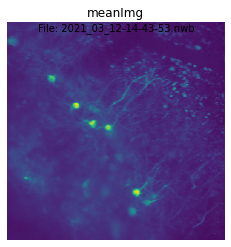

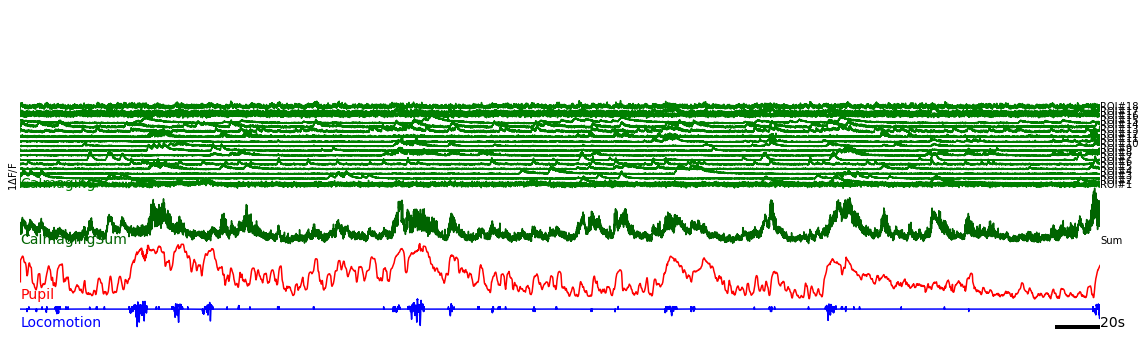

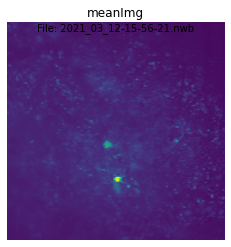

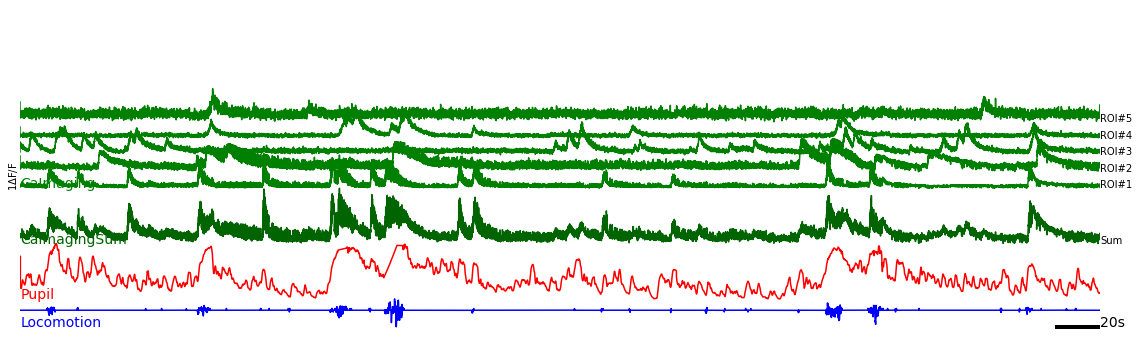

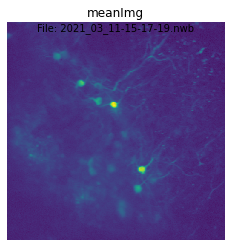

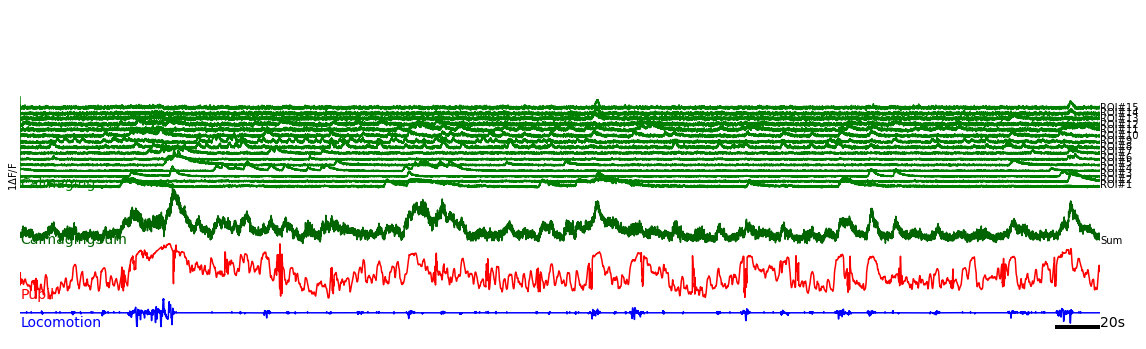

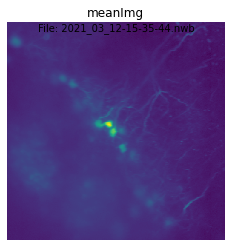

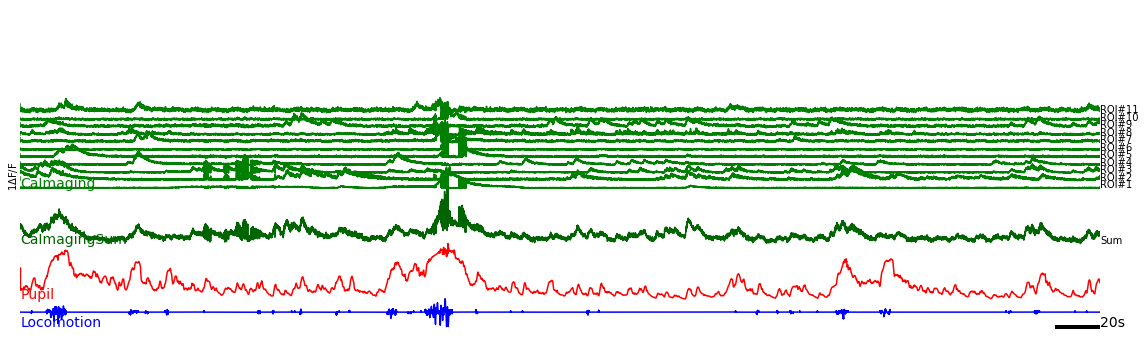

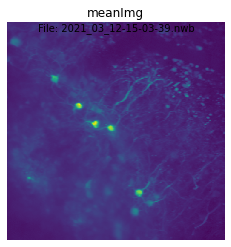

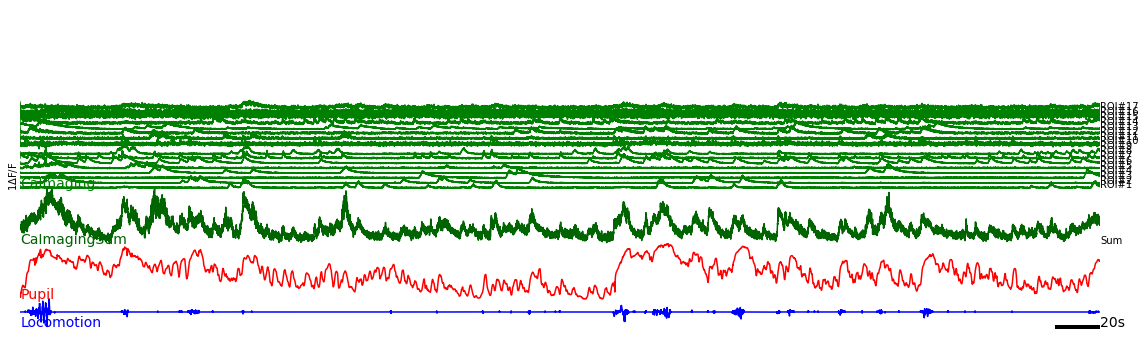

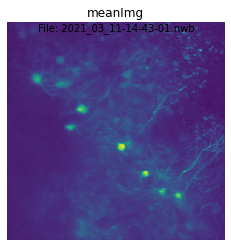

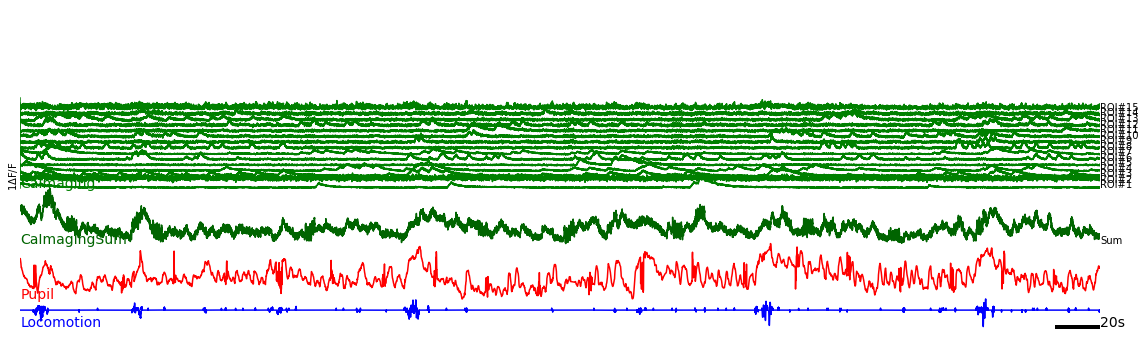

In [5]:
for f in FILENAMES:
    filename = os.path.join(os.path.expanduser('~'), 'DATA', 'NDNF+', f)
    data = MultimodalData(filename, verbose=False)
    try:
        fig0, ax = data.show_CaImaging_FOV(NL=2)
        ax.annotate('File: %s' % f, (0.5,1.), ha='center', va='top', xycoords='axes fraction')
        fig, ax = data.plot([0, 500], 
                 settings={'Locomotion':dict(fig_fraction=1, subsampling=10, color='b'),
                           'Pupil':dict(fig_fraction=2, subsampling=1, color='red'),
                           'CaImagingSum':dict(fig_fraction=2, color='darkgreen', subquantity='dF/F'),
                           'CaImaging':dict(fig_fraction=6, 
                                        quantity='CaImaging', subquantity='dF/F', color='green',
                                                vicinity_factor=2.,
                                        roiIndices='all')})
    except BaseException as be:
        print(be)
        print(f, 'not valid')
    data.io.close()